In [2]:
# %load D:/BUDS_MID/__init__.py
"""
Created on Wed Feb 19 16:21:00 2020

@author: cmchico

usual imports
"""

import os
import pandas as pd
import numpy as np

pd.options.display.max_rows = 100
pd.set_option('display.float_format', '{:.0f}'.format)

from time import time
from datetime import timedelta

import pickle

In [3]:
path = 'D:/BUDS_MID/OJT ATM/ATM Forecasting Data New/'

In [4]:
atm_profile = pd.read_excel(path+'Actual/ATM Profile.xlsx')
atm_profile = atm_profile[atm_profile.TYPE=='ATM'][['TID','Branch Code Orig']].copy()
atm_profile.columns=['TID','BRCODE']
atm_profile['TID'] = atm_profile.TID.astype(str)

In [5]:
df = pd.read_pickle(path+'Actual/82 Aggregated TID WDL.pkl')
df['TID'] = df.TID.astype(str)
dfbr = pd.read_pickle(path+'Actual/82 Aggregated TIDBR WDL.pkl')
dfbr['TID_BR'] = dfbr.TID_BR.astype(str)
df = df.merge(atm_profile, how='left')
df.BRCODE = df.BRCODE.fillna("OFF")


df['TID_BR'] = df.BRCODE.str.upper().str.replace(" ","")
select = df.BRCODE.str.upper().str.contains('OFF')
df.loc[select,'TID_BR'] = df.loc[select,'TID']
df['BR_TIDCOUNT'] = df.TID_BR.map(df.groupby(['TID_BR']).TID.nunique().to_dict())

df['AVE_WDL'] = df.TID.map(df.groupby(['TID']).WDL_AMT.mean().to_dict())
df['AVE_WDL_BRTID'] = df.TID_BR.map(df.groupby('TID_BR').AVE_WDL.mean().to_dict())
df['DIFF'] = df.AVE_WDL_BRTID - df.AVE_WDL
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 936440 entries, 0 to 936439
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   DATE           936440 non-null  datetime64[ns]
 1   TID            936440 non-null  object        
 2   WDL_AMT        936440 non-null  float64       
 3   WDL_AMT_FIN    936440 non-null  float64       
 4   BRCODE         936440 non-null  object        
 5   TID_BR         936440 non-null  object        
 6   BR_TIDCOUNT    936440 non-null  int64         
 7   AVE_WDL        936440 non-null  float64       
 8   AVE_WDL_BRTID  936440 non-null  float64       
 9   DIFF           936440 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(1), object(3)
memory usage: 78.6+ MB


In [11]:
atm_profile_master = df[['TID','TID_BR','BR_TIDCOUNT']].drop_duplicates().reset_index(drop=True)
atm_profile_master.TID = atm_profile_master.TID.astype(str)
atm_profile_master.to_pickle(path+'Actual/89 TID Br map.pkl')

In [6]:
df_ = df[df.BR_TIDCOUNT>1].copy()
df_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 349452 entries, 0 to 933013
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   DATE           349452 non-null  datetime64[ns]
 1   TID            349452 non-null  object        
 2   WDL_AMT        349452 non-null  float64       
 3   WDL_AMT_FIN    349452 non-null  float64       
 4   BRCODE         349452 non-null  object        
 5   TID_BR         349452 non-null  object        
 6   BR_TIDCOUNT    349452 non-null  int64         
 7   AVE_WDL        349452 non-null  float64       
 8   AVE_WDL_BRTID  349452 non-null  float64       
 9   DIFF           349452 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(1), object(3)
memory usage: 29.3+ MB


In [7]:
df_[df_.TID_BR=='BR054'].TID.unique()

array(['91010018', '91016429'], dtype=object)

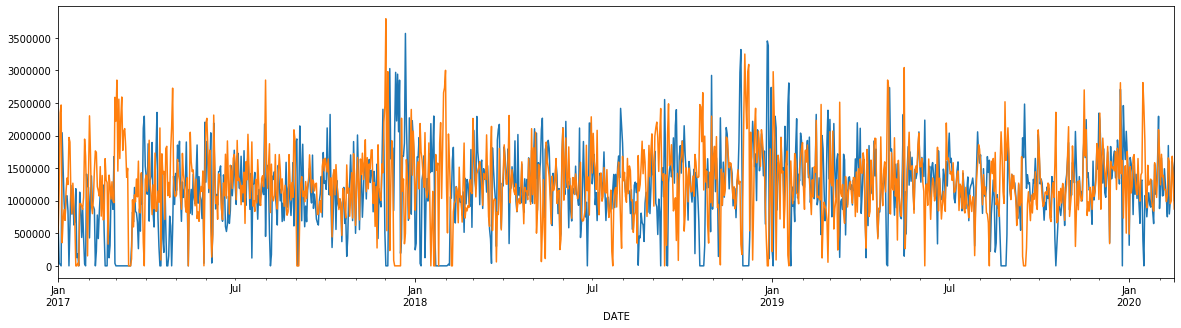

In [8]:
df[df.TID=='91010018'].set_index('DATE').WDL_AMT.plot(figsize=(20,5))
df[df.TID=='91016429'].set_index('DATE').WDL_AMT.plot(figsize=(20,5))

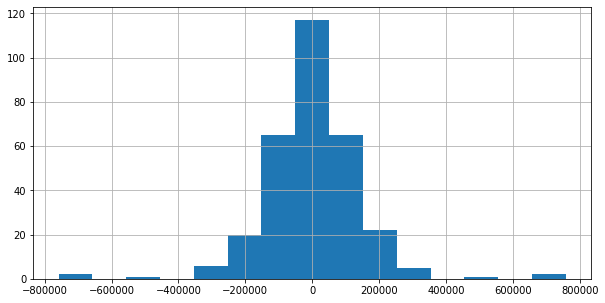

In [9]:
df2 = df_[['TID','TID_BR','AVE_WDL', 'AVE_WDL_BRTID','DIFF']].drop_duplicates().sort_values('TID_BR')
df2.DIFF.hist(bins=15, figsize=(10,5))

the average demand of a TID is similar across TIDs within a branch. varying about by 400,000
extreme ones vary by 600.00 but too little to care na :)

this means that all tids within the branch have individual demands... :p